In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import timm
import os
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from skimage import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import random

## Cuda


In [2]:
#Controllo che torch sia installato con CUDA abilitato
def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

In [3]:
print(torch.version.cuda)

11.7


## Model parameters


In [27]:
model_weights = False

In [5]:
#Directory per i file di train
DATA_DIR = ''

#Grandezza del Batch (iperparametro)
BATCH_SIZE = 32

#Learning Rate (Iperparametro)
LR = 0.001

#Numero di epoche (Iperparametro)
EPOCHS = 80

DEVICE = 'cuda'

## Dataloader and dataset creation

In [6]:
# Carica il file csv
df_real = pd.read_csv("real_image_dataset_coco2.csv")

df_fake = pd.read_csv("fake_image_dataset_biggan_latent_taming.csv")

train_df_real, valid_df_real = train_test_split(df_real, test_size = 0.20, random_state = 42)
train_df_fake, valid_df_fake = train_test_split(df_fake, test_size = 0.20, random_state = 42)

test_df_real = train_df_real.sample(500)
test_df_fake = train_df_fake.sample(500)

train_df_real = train_df_real.drop(test_df_real.index)
train_df_fake = train_df_fake.drop(test_df_fake.index)

train_df = pd.concat([train_df_real, train_df_fake])
valid_df = pd.concat([valid_df_real, valid_df_fake])

test_df = pd.concat([test_df_fake, test_df_real])

# shuffle
train_df= train_df.sample(frac= 1)
valid_df= valid_df.sample(frac= 1)

# Unisci tutti i dataframe in un unico dataframe finale per il train set
final_df = pd.concat([train_df, valid_df])

# Salva il dataframe finale di trian in un file CSV
final_df.to_csv("spectrum_train_dataset_2train.csv", index=False)
df = pd.read_csv("spectrum_train_dataset_2train.csv")

# Crea una lista combinata con 500 immagini false seguite da 500 immagini reali
combined_images = test_df["Anchor"]

# Crea il dataframe del test set con una sola colonna
test_df = pd.DataFrame(combined_images)

# Salva il dataframe del test set in un file CSV
test_df.to_csv("test_set_biggan_2train.csv", index=False, header=False)

print('Size of train set:', len(train_df))
print('Size of valid set:', len(valid_df))
print('Size of test set:', len(test_df))

Size of train set: 23000
Size of valid set: 6000
Size of test set: 1000


In [7]:
# Carico le immagini del file CSV che ho fornito, per settarle in modo corretto e darle in input alla rete neurale
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor, as_gray= True)
    P_img = io.imread(DATA_DIR + row.Positive, as_gray= True)
    N_img = io.imread(DATA_DIR + row.Negative, as_gray= True)

    
    # Aggiungi dimensione per il batch
    A_img = np.expand_dims(A_img, 0)
    P_img = np.expand_dims(P_img, 0)
    N_img = np.expand_dims(N_img, 0)

    A_img = torch.from_numpy(A_img)/ 255.0
    P_img = torch.from_numpy(P_img)/ 255.0
    N_img = torch.from_numpy(N_img)/ 255.0
      
    #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [8]:
data = APN_Dataset(train_df)
item1, item2, item3 = data.__getitem__(0)
print(item1.shape)

torch.Size([1, 200, 200])


Qui di seguito mi stampo il numero che compone l'insieme di dati di train, test e validation

In [9]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
testset = APN_Dataset(test_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")
print(f"Size of validset: {len(testset)}")

Size of trainset: 23000
Size of validset: 6000
Size of validset: 1000


Carichiamo i dati di train e validation nella batch

In [10]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
testloader = DataLoader(testset, batch_size = 1)

In [11]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")
print(f"No. of batches in testloader : {len(testloader)}")

No. of batches in trainloader : 719
No. of batches in validloader : 188
No. of batches in testloader : 1000


Questa funzione definisce un modello di rete neurale chiamato APN_Model, che carica un'architettura di rete preaddestrata e sostituisce il classificatore finale con un nuovo classificatore personalizzato.

## Model definition

In [12]:
#Carico il modello di rete neurale
class APN_Model(nn.Module):

    #Viene definita la size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    #QUI CAIRCATE IL MODELLO, IN QUESTO CASO EFFICIENTNET VERSIONE B0 (LA PIù LEGGERA DELLA FAMIGLIA)
    self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [13]:
#QUI FATE UNA PICCOLA MODIFICA ALLA RETE PER FARLE AVERE IN INPUT IMMAGINI IN SCALA DI GRIGIO DELLO SPETTRO DI FOURIER
model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False);

if model_weights == True :
    model.load_state_dict(torch.load('trained_model_on_30000.pt'))

model.to(DEVICE);

## Evaluation functions

In [14]:
#FUNZIONE DI TRAINING
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
#FUNZIONE DI EVALUATION
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.model = None

    def early_stop(self, validation_loss, model_updated):
        print(validation_loss)
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("New min - model updated")
            self.model = model_updated
            torch.save(self.model, 'trained_model_on_30000.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print(f"Counter updated {self.min_validation_loss + self.min_delta}")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def get_model(self):
        return self.model

## Training parameters

In [17]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [18]:
early_stopper = EarlyStopper(patience=5, min_delta=0.08)

## Training

In [19]:
#Training
if model_weights == False :
    best_valid_loss = np.Inf
    training_loss = []
    validation_loss = []
    for i in range(EPOCHS):
      train_loss = train_fn(model, trainloader, optimizer, criterion)
      valid_loss = eval_fn(model, validloader, criterion)
      training_loss.append(train_loss)
      validation_loss.append(valid_loss)
      if early_stopper.early_stop(valid_loss, model.state_dict()):             
          break
          
      print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")
    torch.save(early_stopper.get_model(), 'trained_model_on_30000.pt')


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.20it/s]


0.7192343869741927
New min - model updated
EPOCHS : 1 train_loss : 0.8170401897068978 valid_loss : 0.7192343869741927


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.7224477034934024
EPOCHS : 2 train_loss : 0.6945472829282201 valid_loss : 0.7224477034934024


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.7837058917639104
EPOCHS : 3 train_loss : 0.7114174583400904 valid_loss : 0.7837058917639104


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.7164553321422414
New min - model updated
EPOCHS : 4 train_loss : 0.7055053863057839 valid_loss : 0.7164553321422414


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:40<00:00,  4.59it/s]


0.73924446740049
EPOCHS : 5 train_loss : 0.7747919505179675 valid_loss : 0.73924446740049


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.8439772991423912
Counter updated 0.7964553321422414
EPOCHS : 6 train_loss : 0.7405404881243911 valid_loss : 0.8439772991423912


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.7504221974535191
EPOCHS : 7 train_loss : 0.7622870206418388 valid_loss : 0.7504221974535191


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.7406864729016385
EPOCHS : 8 train_loss : 0.7337304153926515 valid_loss : 0.7406864729016385


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.7155153301167996
New min - model updated
EPOCHS : 9 train_loss : 0.7257492780809773 valid_loss : 0.7155153301167996


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.53it/s]


0.7783163540223812
EPOCHS : 10 train_loss : 0.7097290583338293 valid_loss : 0.7783163540223812


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.53it/s]


0.7327708235763489
EPOCHS : 11 train_loss : 0.7136731116367978 valid_loss : 0.7327708235763489


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.7150992261285477
New min - model updated
EPOCHS : 12 train_loss : 0.7232170364040991 valid_loss : 0.7150992261285477


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.7106369792463931
New min - model updated
EPOCHS : 13 train_loss : 0.721102790246421 valid_loss : 0.7106369792463931


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.53it/s]


0.7533727250200637
EPOCHS : 14 train_loss : 0.7449070130356993 valid_loss : 0.7533727250200637


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.7331605055864822
EPOCHS : 15 train_loss : 0.7182482083189471 valid_loss : 0.7331605055864822


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.52it/s]


0.7331245831669645
EPOCHS : 16 train_loss : 0.753321302787858 valid_loss : 0.7331245831669645


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.7426550924143893
EPOCHS : 17 train_loss : 0.6864430925320518 valid_loss : 0.7426550924143893


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.7126139725776429
EPOCHS : 18 train_loss : 0.6542776308394191 valid_loss : 0.7126139725776429


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.52it/s]


0.7446682526076094
EPOCHS : 19 train_loss : 0.6558934287614965 valid_loss : 0.7446682526076094


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6990506195641578
New min - model updated
EPOCHS : 20 train_loss : 0.7033221017729921 valid_loss : 0.6990506195641578


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.699779490048581
EPOCHS : 21 train_loss : 0.6724731512108665 valid_loss : 0.699779490048581


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.71124454270652
EPOCHS : 22 train_loss : 0.665941401295395 valid_loss : 0.71124454270652


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.733051506445763
EPOCHS : 23 train_loss : 0.6338287749028504 valid_loss : 0.733051506445763


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.6873514737854612
New min - model updated
EPOCHS : 24 train_loss : 0.6370928451905911 valid_loss : 0.6873514737854612


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.53it/s]


0.6947304921898436
EPOCHS : 25 train_loss : 0.6497198569281376 valid_loss : 0.6947304921898436


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:40<00:00,  4.59it/s]


0.7327040492537173
EPOCHS : 26 train_loss : 0.6000139202938126 valid_loss : 0.7327040492537173


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.7269280787478102
EPOCHS : 27 train_loss : 0.6097698166645203 valid_loss : 0.7269280787478102


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6951656848826306
EPOCHS : 28 train_loss : 0.5898951863266414 valid_loss : 0.6951656848826306


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.6897830243440385
EPOCHS : 29 train_loss : 0.5936533475608172 valid_loss : 0.6897830243440385


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6672882228455645
New min - model updated
EPOCHS : 30 train_loss : 0.572336750599829 valid_loss : 0.6672882228455645


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.7000843787446935
EPOCHS : 31 train_loss : 0.5617278278164141 valid_loss : 0.7000843787446935


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6663984470862023
New min - model updated
EPOCHS : 32 train_loss : 0.568357817403796 valid_loss : 0.6663984470862023


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.6682785598838583
EPOCHS : 33 train_loss : 0.5597203265362638 valid_loss : 0.6682785598838583


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6489975046604237
New min - model updated
EPOCHS : 34 train_loss : 0.5540562375436986 valid_loss : 0.6489975046604237


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6534200982844576
EPOCHS : 35 train_loss : 0.5554866912011809 valid_loss : 0.6534200982844576


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.6569268246914478
EPOCHS : 36 train_loss : 0.5444812913670078 valid_loss : 0.6569268246914478


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.64571162107143
New min - model updated
EPOCHS : 37 train_loss : 0.5268096827094926 valid_loss : 0.64571162107143


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.6910584221812005
EPOCHS : 38 train_loss : 0.52516532569647 valid_loss : 0.6910584221812005


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.8401971174047348
Counter updated 0.72571162107143
EPOCHS : 39 train_loss : 0.5034753980998452 valid_loss : 0.8401971174047348


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6671831779023434
EPOCHS : 40 train_loss : 0.5375110401936466 valid_loss : 0.6671831779023434


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6472836266806785
EPOCHS : 41 train_loss : 0.5178131972684399 valid_loss : 0.6472836266806785


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6690815958253881
EPOCHS : 42 train_loss : 0.5152803307738523 valid_loss : 0.6690815958253881


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.6478535948281593
EPOCHS : 43 train_loss : 0.5185437767101926 valid_loss : 0.6478535948281593


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.630881537782385
New min - model updated
EPOCHS : 44 train_loss : 0.49232768181385017 valid_loss : 0.630881537782385


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.6369765908160108
EPOCHS : 45 train_loss : 0.49518087916646114 valid_loss : 0.6369765908160108


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6404300504859458
EPOCHS : 46 train_loss : 0.48458181108673193 valid_loss : 0.6404300504859458


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6237899665027222
New min - model updated
EPOCHS : 47 train_loss : 0.4664975872395433 valid_loss : 0.6237899665027222


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.6560686444665523
EPOCHS : 48 train_loss : 0.48888512341220125 valid_loss : 0.6560686444665523


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.6486551490552882
EPOCHS : 49 train_loss : 0.47080248012952247 valid_loss : 0.6486551490552882


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.53it/s]


0.6587210070896656
EPOCHS : 50 train_loss : 0.4507512846684423 valid_loss : 0.6587210070896656


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6442790080575233
EPOCHS : 51 train_loss : 0.4263973699543257 valid_loss : 0.6442790080575233


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6744838734256461
EPOCHS : 52 train_loss : 0.4667443694994993 valid_loss : 0.6744838734256461


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.6240189952102113
EPOCHS : 53 train_loss : 0.4753641409796866 valid_loss : 0.6240189952102113


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.53it/s]


0.642395372244906
EPOCHS : 54 train_loss : 0.4381467959479596 valid_loss : 0.642395372244906


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:40<00:00,  4.60it/s]


0.620584323843743
New min - model updated
EPOCHS : 55 train_loss : 0.4149270453937196 valid_loss : 0.620584323843743


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6133914054074185
New min - model updated
EPOCHS : 56 train_loss : 0.4244701100438211 valid_loss : 0.6133914054074185


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6461220748246984
EPOCHS : 57 train_loss : 0.4106996232573777 valid_loss : 0.6461220748246984


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6416813269891637
EPOCHS : 58 train_loss : 0.39441728048928093 valid_loss : 0.6416813269891637


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6112183538523126
New min - model updated
EPOCHS : 59 train_loss : 0.3900452643912674 valid_loss : 0.6112183538523126


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.5913300967596947
New min - model updated
EPOCHS : 60 train_loss : 0.3804694965264147 valid_loss : 0.5913300967596947


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.6356990535525565
EPOCHS : 61 train_loss : 0.3794617887705523 valid_loss : 0.6356990535525565


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6460846137810261
EPOCHS : 62 train_loss : 0.3629230740888145 valid_loss : 0.6460846137810261


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6077696031078379
EPOCHS : 63 train_loss : 0.37740998906348944 valid_loss : 0.6077696031078379


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.6045113093358405
EPOCHS : 64 train_loss : 0.3775004521064118 valid_loss : 0.6045113093358405


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.6193039854790302
EPOCHS : 65 train_loss : 0.3780428448456219 valid_loss : 0.6193039854790302


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6690541959189354
EPOCHS : 66 train_loss : 0.3663568728925953 valid_loss : 0.6690541959189354


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.5946902101661297
EPOCHS : 67 train_loss : 0.36110783806679475 valid_loss : 0.5946902101661297


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.5951249976741507
EPOCHS : 68 train_loss : 0.31859766971708503 valid_loss : 0.5951249976741507


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.5976397590117252
EPOCHS : 69 train_loss : 0.3220210766241017 valid_loss : 0.5976397590117252


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.55it/s]


0.5976394032861324
EPOCHS : 70 train_loss : 0.2905807241160158 valid_loss : 0.5976394032861324


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.6137205589007824
EPOCHS : 71 train_loss : 0.3198329083497153 valid_loss : 0.6137205589007824


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.5891048245607539
New min - model updated
EPOCHS : 72 train_loss : 0.2918968483474059 valid_loss : 0.5891048245607539


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.6079875345718353
EPOCHS : 73 train_loss : 0.301928304643558 valid_loss : 0.6079875345718353


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.57it/s]


0.5931268527786783
EPOCHS : 74 train_loss : 0.2893181825794995 valid_loss : 0.5931268527786783


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.5775445730603755
New min - model updated
EPOCHS : 75 train_loss : 0.2895687969300445 valid_loss : 0.5775445730603755


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]


0.5876003776458983
EPOCHS : 76 train_loss : 0.2619566819390932 valid_loss : 0.5876003776458983


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.5853090091271603
EPOCHS : 77 train_loss : 0.26676661475601715 valid_loss : 0.5853090091271603


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.58it/s]


0.5481285257859433
New min - model updated
EPOCHS : 78 train_loss : 0.2477194700229483 valid_loss : 0.5481285257859433


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.56it/s]


0.5660873494566755
EPOCHS : 79 train_loss : 0.2441465826562615 valid_loss : 0.5660873494566755


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:41<00:00,  4.54it/s]

0.5648045427700941
EPOCHS : 80 train_loss : 0.22897186578459966 valid_loss : 0.5648045427700941


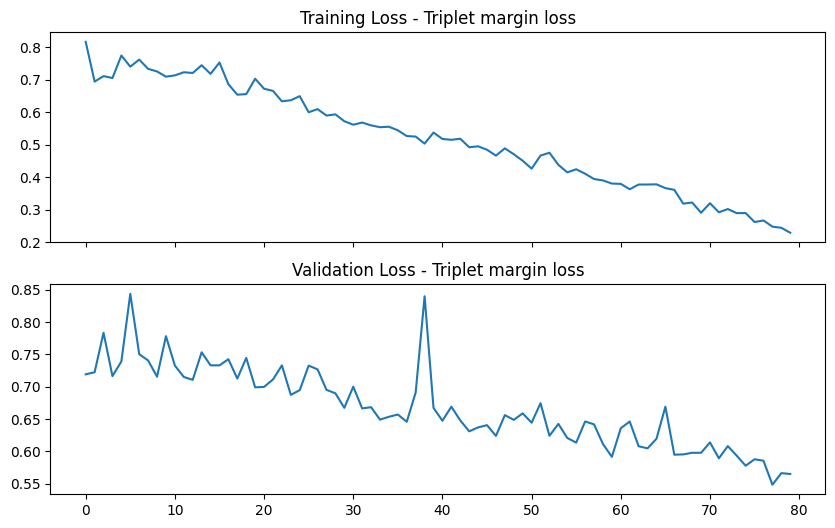

In [20]:
#Salvataggio plottato dei dati
if(model_weights == False):    
    fig, axes = plt.subplots(2, 1, sharex= True, figsize=(10, 6))
    axes[0].plot(training_loss)
    axes[0].set_title('Training Loss - Triplet margin loss')
    axes[1].plot(validation_loss)
    axes[1].set_title('Validation Loss - Triplet margin loss')
    plt.savefig('training_data_30000(biggan_latent_taming)-80-epochs.png')
    plt.show()

## Databse training embedded

In [25]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
# concatenating images name and relative encodings
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(dirFolder + i)
      A = np.expand_dims(A, 0)
      A = torch.from_numpy(A.astype(np.int32)) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [29]:
#QUI CREO IL DATABASE DI FEATURE VECTORS DEL TRAINING SET
df_enc = get_encoding_csv(model, df['Anchor'], DATA_DIR)

100%|████████████████████████████████████████████████████████████████████████████| 29000/29000 [05:28<00:00, 88.29it/s]


In [30]:
#QUI IL DATABASE COME CSV IN MODO TALE DA NON DOVER FARE QUESTA OPERAZIONE OGNI VOLTA
#OVVIAMENTE, SE DEVO FARE UN NUOVO TRAINING DEVO ANCHE RICREARE GLI ENCODINGS
if(model_weights == False):
    df_enc.to_csv('database_embed_(biggan_latent_taming-coco).csv', index = False)
    df_enc.head()
else:
    df_enc = pd.read_csv('database_embed_(biggan_latent_taming-coco).csv')

## Distances, Get image embeddings and searching in databse

In [31]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    #dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [32]:
# return the embedding of the image
def getImageEmbeddings(img, model):

    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    model.eval();

    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

## Adding 5 Latent Diffusion, 5 Taming Transformer

In [33]:
(df_enc.describe())

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,...,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000
mean,-0.216455,-0.712977,1.114976,0.722931,-1.031491,-0.648398,-1.089123,0.231121,-1.057077,-0.677287,...,-1.376856,1.351983,0.940181,0.407899,0.631123,-2.134335,0.596049,1.406200,-1.537396,-0.314871
std,0.001285,0.009445,0.003208,0.002476,0.006039,0.002247,0.008073,0.001865,0.003734,0.004002,...,0.005824,0.004717,0.003489,0.003556,0.008372,0.006175,0.002395,0.003844,0.007012,0.002194
min,-0.221841,-0.738009,1.101873,0.713073,-1.058341,-0.657568,-1.111069,0.224129,-1.071593,-0.693642,...,-1.406101,1.334850,0.926909,0.397657,0.602113,-2.159127,0.584007,1.389530,-1.574284,-0.321045
25%,-0.217318,-0.720305,1.112847,0.721310,-1.036531,-0.649827,-1.094884,0.229904,-1.059466,-0.680645,...,-1.380903,1.348635,0.937882,0.405249,0.624350,-2.138249,0.594595,1.403917,-1.542023,-0.316815
50%,-0.216537,-0.716266,1.114804,0.722644,-1.030155,-0.648342,-1.090748,0.230930,-1.056882,-0.676477,...,-1.377438,1.351389,0.939661,0.406692,0.633446,-2.134074,0.596252,1.406089,-1.538113,-0.314994
75%,-0.215632,-0.704340,1.116990,0.724579,-1.027401,-0.646978,-1.082842,0.232133,-1.054591,-0.674365,...,-1.373183,1.354928,0.942749,0.411458,0.637273,-2.130281,0.597638,1.408526,-1.532991,-0.312833
max,-0.209728,-0.683712,1.132569,0.735858,-1.012226,-0.638531,-1.061427,0.239395,-1.041203,-0.665591,...,-1.352973,1.374712,0.956903,0.418860,0.651853,-2.107503,0.603344,1.427005,-1.507892,-0.309354


In [58]:
# Funzione per ottenere i percorsi delle immagini
#def get_image_paths(folder):
    #image_paths = []
    #for root, dirs, files in os.walk(folder):
        #for filename in files:
            #if filename.endswith(".jpg"):
                #image_paths.append(os.path.relpath(os.path.join(root, filename)))
    #return image_paths

In [59]:
#current_dir = os.getcwd()
#fake_image_folder_latent = os.path.join(current_dir, "dataset", "latent_diffusion", "latentdiff-t2i_spectrum")
#fake_image_folder_taming = os.path.join(current_dir, "dataset", "taming_transformer", "tt-ffhq_spectrum")

#fake_image_paths_latent = get_image_paths(fake_image_folder_latent)
#fake_image_paths_taming = get_image_paths(fake_image_folder_taming)

#print("Numero di immagini latenti:", len(fake_image_paths_latent))
#print("Numero di immagini taming:", len(fake_image_paths_taming))

# Selezionare un numero casuale di immagini
#num_random_elements = 4000
#taming_random = random.sample(fake_image_paths_taming, num_random_elements)
#latent_random = random.sample(fake_image_paths_latent, num_random_elements)

# Ottenere gli embedding delle immagini selezionate
#embeddings_new_taming_latent_imgs = []
#image_paths = []

#for i in range(num_random_elements):
    #taming_random_img = io.imread(taming_random[i])
    #latent_random_img = io.imread(latent_random[i])
    #taming_random_img_embed = getImageEmbeddings(taming_random_img, model)[0, :]
    #latent_random_img_embed = getImageEmbeddings(latent_random_img, model)[0, :]
    #embeddings_new_taming_latent_imgs.append(taming_random_img_embed)
    #embeddings_new_taming_latent_imgs.append(latent_random_img_embed)
    #image_paths.append(taming_random[i])
    #image_paths.append(latent_random[i])

Numero di immagini latenti: 10000
Numero di immagini taming: 50000


In [60]:
# Creare un DataFrame con gli embedding e i percorsi delle immagini
#df_latent_taming_new = pd.DataFrame(embeddings_new_taming_latent_imgs)
#df_latent_taming_new['Anchor'] = image_paths

# Verifica del DataFrame creato
#print("Nuovo DataFrame con embedding e percorsi delle immagini:")
#print(df_latent_taming_new.head())

# Concatenare con il DataFrame esistente
#df_enc_plus_latent_taming = pd.concat([df_enc, df_latent_taming_new], ignore_index=True)

# Salviamo il DataFrame risultante in un CSV
#df_enc_plus_latent_taming.to_csv('new_database_with(4000-latent_4000-taming).csv', index=False)

#saved_df = pd.read_csv('new_database_with(4000-latent_4000-taming).csv')

Nuovo DataFrame con embedding e percorsi delle immagini:
          0         1         2         3         4         5         6  \
0 -0.827468  1.136841 -0.155556  2.287536 -1.014439  0.602299  1.084135   
1 -0.922864  1.199418 -0.157046  2.421353 -1.141831  0.582684  1.183484   
2 -0.816880  1.140402 -0.156049  2.289874 -1.013697  0.610544  1.079931   
3 -0.887379  1.202078 -0.149548  2.403862 -1.111866  0.603006  1.161297   
4 -0.823692  1.136343 -0.155157  2.285830 -1.015867  0.602834  1.081841   

          7         8         9  ...       503       504       505       506  \
0 -0.797319  0.851734 -0.285401  ...  0.992008  0.410795 -2.245780  3.608075   
1 -0.785001  0.947947 -0.232244  ...  1.092803  0.467504 -2.385423  3.758266   
2 -0.809154  0.851175 -0.300426  ...  0.986880  0.412562 -2.245290  3.627715   
3 -0.816646  0.923687 -0.264882  ...  1.065754  0.457261 -2.361717  3.768892   
4 -0.799876  0.852705 -0.288892  ...  0.990214  0.411956 -2.243192  3.609420   

        507

In [39]:
# return the closest image in the database given an img_enc
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database['Anchor']

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)
    
    closest_idx = np.argsort(distance)

    return database['Anchor'][closest_idx[0]]

# Defining test list

In [40]:
test = "test_set_biggan-latent-taming-coco_2train.csv"
test_latent = pd.read_csv(test, header = None)

## Testing

In [41]:
database = df_enc
(database.describe())
y_true = ['fake'] * 500 + ['real'] * 500
y_pred = []

In [42]:
def test_images(test_df, start_index, end_index, database, model):
    for index, row in tqdm(test_df.iloc[start_index:end_index].iterrows(), total=end_index-start_index):
        img_name = row[0] # Accesso diretto alla prima (e unica) colonna

        # Verifica se il nome del file è valido
        if pd.isnull(img_name) or not os.path.isfile(img_name):
            print(f"Invalid image file path at index {index}: {img_name}")
            y_pred.append("error")
            continue
        
        # Leggi e processa l'immagine
        img = io.imread(img_name)

        # Ottieni gli embeddings dell'immagine
        img_enc = getImageEmbeddings(img, model)

        # Cerca nel database
        closestLabel = searchInDatabase(img_enc, database)
       
        # Aggiungi la predizione alla lista
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

In [43]:
test_images(test_latent, 0, 1000, database, model)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:48<00:00,  2.45it/s]


In [44]:
#Creo i vettori di ground truth
y_true = np.array(['fake'] * 500)
print(y_true.shape)

temp = np.array(['real'] * 500)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

#Calcolo la matrice di confusione
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])

(500,)
(500,)
(1000,)


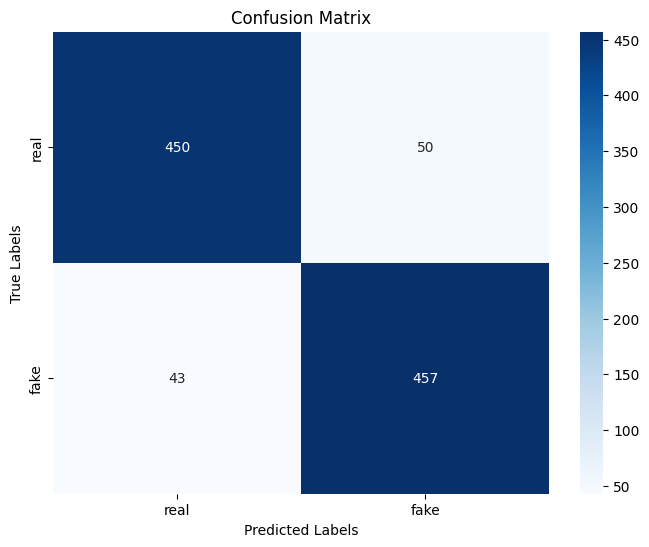

In [45]:
#Estraggo dalla matrice di confusione i True Negative, False Positive, False Negative, True Positive
TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()

# Plotto la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# Salvo l'immagine
plt.savefig('confusion_matrix_1000(biggan_latent_taming-coco)_second_series-test.png')
plt.show()

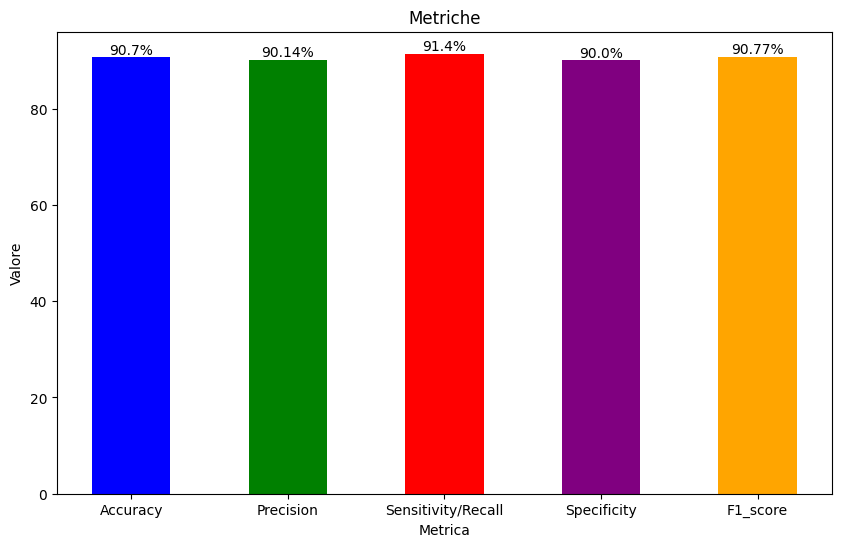

In [46]:
#Calcolo alcune metriche per vedere come si comporta
accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
sensitivy_recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Sensitivity/Recall": sensitivy_recall,
    "Specificity": specificity,
    "F1_score": F1_score
}

# Nomi delle metriche
labels = list(metrics.keys())

# Valori delle metriche
values = list(metrics.values())

# Creazione dell'istogramma
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)

# Aggiunta delle etichette
for i in range(len(labels)):
    plt.text(i, values[i], f'{values[i]}%', ha = 'center', va = 'bottom')

# Titoli e etichette degli assi
plt.title('Metriche')
plt.xlabel('Metrica')
plt.ylabel('Valore')

plt.savefig('Metrics_with_biggan_latent_taming-coco_second_series_test.png')

# Mostra l'istogramma
plt.show()

In [47]:
print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})

{'Accuracy': 90.7, 'Precision': 90.14, 'Sensitivity_recall': 91.4, 'Specificity': 90.0, 'F1_score': 90.77}


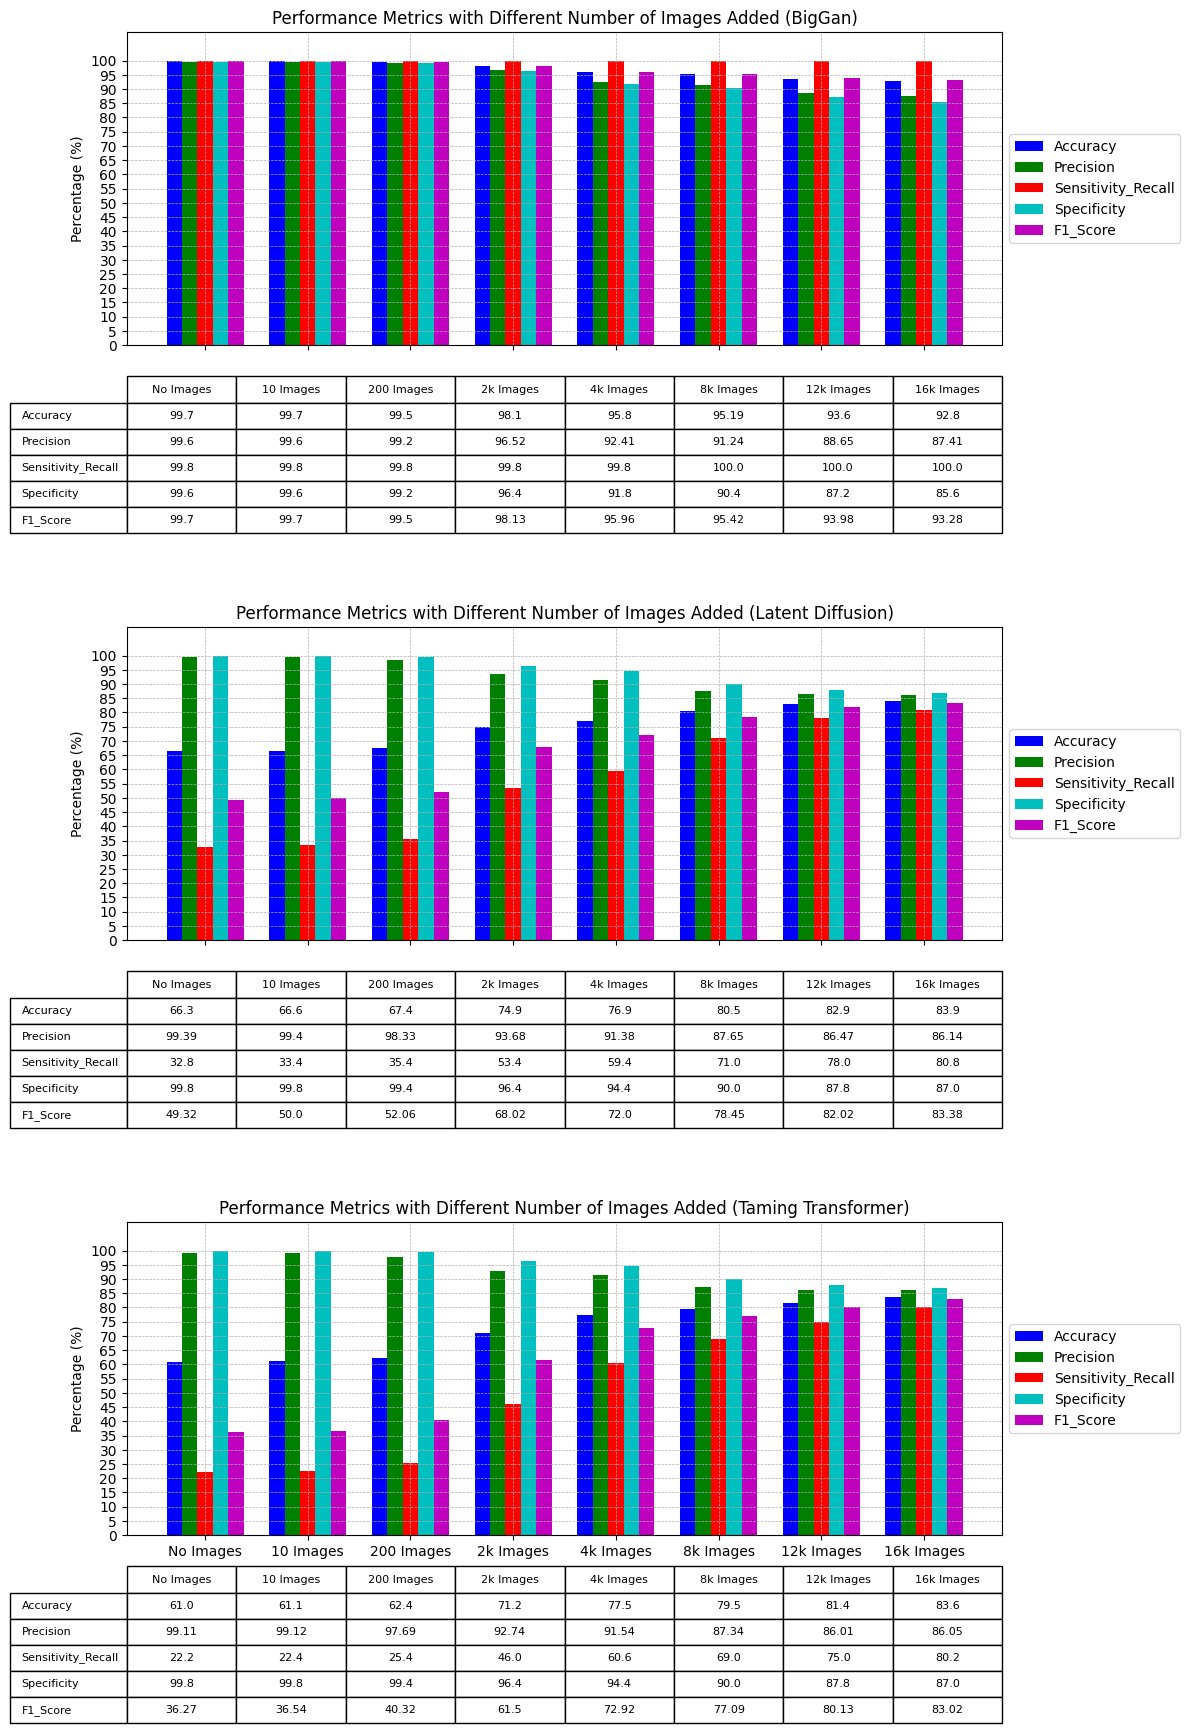

In [42]:
conditions = ['No Images', '10 Images', '200 Images', '2k Images', '4k Images', '8k Images', '12k Images', '16k Images']
metrics = ['Accuracy', 'Precision', 'Sensitivity_Recall', 'Specificity', 'F1_Score']
data1 = {
    'Accuracy': [99.7, 99.7, 99.5, 98.1, 95.8, 95.19, 93.60, 92.80],
    'Precision': [99.6, 99.6, 99.2, 96.52, 92.41, 91.24, 88.65, 87.41],
    'Sensitivity_Recall': [99.8, 99.8, 99.8, 99.8, 99.8, 100, 100, 100],
    'Specificity': [99.6, 99.6, 99.2, 96.4, 91.8, 90.4, 87.2, 85.6],
    'F1_Score': [99.7, 99.7, 99.5, 98.13, 95.96, 95.42, 93.98, 93.28]
}
data2 = {
    'Accuracy': [66.3, 66.60, 67.4, 74.9, 76.9, 80.5, 82.90, 83.90],
    'Precision': [99.39, 99.4, 98.33, 93.68, 91.38, 87.65, 86.47, 86.14],
    'Sensitivity_Recall': [32.80, 33.4, 35.4, 53.40, 59.4, 71.0, 78.0, 80.80],
    'Specificity': [99.8, 99.8, 99.4, 96.4, 94.4, 90.0, 87.8, 87.0],
    'F1_Score': [49.32, 50.0, 52.06, 68.02, 72.0, 78.45, 82.02, 83.38]
}
data3 = {
    'Accuracy': [61.0, 61.1, 62.4, 71.2, 77.5, 79.5, 81.40, 83.6],
    'Precision': [99.11, 99.12, 97.69, 92.74, 91.54, 87.34, 86.01, 86.05],
    'Sensitivity_Recall': [22.2, 22.40, 25.4, 46.0, 60.6, 69.0, 75.0, 80.2],
    'Specificity': [99.8, 99.8, 99.4, 96.4, 94.4, 90.0, 87.8, 87.0],
    'F1_Score': [36.27, 36.54, 40.32, 61.5, 72.92, 77.09, 80.13, 83.02]
}

# Parametri di configurazione
bar_width = 0.15  # Larghezza delle barre
index = np.arange(len(conditions))  # Posizioni delle condizioni sull'asse x
colors = ['b', 'g', 'r', 'c', 'm']  # Colori delle barre

# Creazione della figura e degli assi
fig, axs = plt.subplots(nrows=3, figsize=(12, 18), sharex=True)

for ax in axs:
    ax.set_xticks(index + 2 * bar_width)
    ax.set_xticklabels(conditions)

# Funzione per plottare i dati in un subplot
def plot_metrics(ax, data, title):
    for i, metric in enumerate(metrics):
        bars = ax.bar(index + i * bar_width, data[metric], bar_width, label=metric, color=colors[i])
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title)
    ax.set_ylim(0, 110)  # Aumenta il limite superiore per spazio extra
    ax.set_yticks(np.arange(0, 101, 5))  # Tacche sull'asse y ogni 5%
    # Aggiunta delle linee della griglia per ogni tick
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Creazione della tabella con i valori
    table_data = [data[metric] for metric in metrics]
    row_labels = metrics
    col_labels = conditions
    table_data = np.round(np.array(table_data), 2)

    # Aggiunta della tabella accanto al grafico
    table = ax.table(cellText=table_data, rowLabels=row_labels, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0, -0.6, 1, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)  # Regola la dimensione della tabella
    
# Plot dei dati
plot_metrics(axs[0], data1, 'Performance Metrics with Different Number of Images Added (BigGan)')
plot_metrics(axs[1], data2, 'Performance Metrics with Different Number of Images Added (Latent Diffusion)')
plot_metrics(axs[2], data3, 'Performance Metrics with Different Number of Images Added (Taming Transformer)')

plt.tight_layout()
plt.savefig('Concat_Metrics.png')    
plt.show()